In [374]:
import pandas as pd
import seaborn as sns
import re
from pathlib import Path
import matplotlib.pyplot as plt

import numpy as np

sns.set()

BASE_PATH = Path("../DATASETS/disaster-tweet/")

## Loading and getting basic idea

In [297]:
train = pd.read_csv(BASE_PATH/'train.csv')

In [298]:
train.head(4)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1


In [299]:
print(f"There are {train.shape[0]} rows and {train.shape[1]} columns in the training set")

There are 7613 rows and 5 columns in the training set


### Checking Class Distributions 

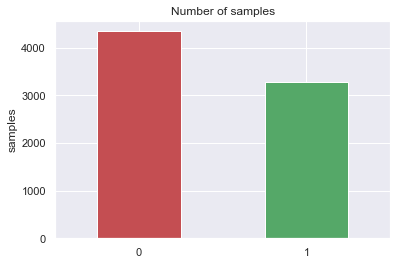

In [300]:
train['target'].value_counts().plot.\
                bar(title = 'Number of samples', color = ['r', 'g']).\
                set_ylabel("samples")
plt.xticks(rotation = 0)
plt.show()

#### Checking Missing Values

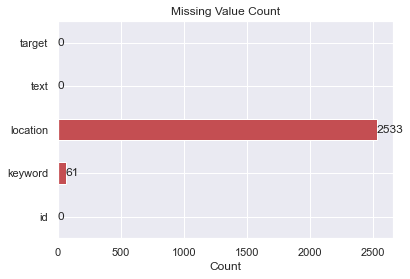

In [301]:
ax = train.isna().sum().plot.barh(title = 'Missing Value Count', color='r')
ax.set_xlabel("Count")

for container in ax.containers:
    ax.bar_label(container)

#### Analysing

In [302]:
DISASTER_TWEETS = train['target'] == 1

def histplot(column, ax, title, **kwarg):
    sns.histplot(train[~DISASTER_TWEETS][column], ax=ax, color='green', label="Disaster Tweet", **kwarg)
    sns.histplot(train[DISASTER_TWEETS][column], ax=ax, color='red', label="Normal Tweet", **kwarg)
    ax.legend()
    ax.set_xlabel('')
    ax.set_title(title)

In [303]:
train['word_count'] = train['text'].map(lambda x: len(x.split()))
train['char_count'] = train['text'].map(len)
train['unique_word_count'] = train['text'].map(lambda x: len(set(x.split())))
train['average_word_length'] = train['text'].map(lambda x: np.mean([len(word) for word in x.split()]))

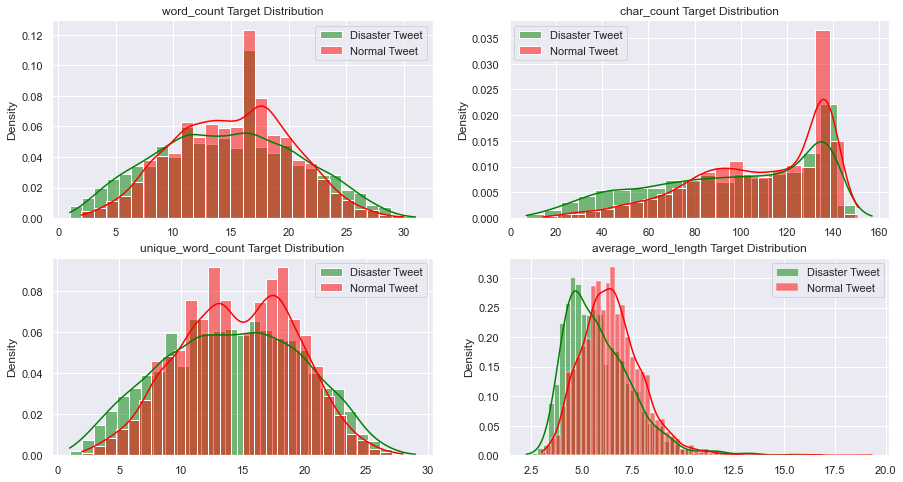

In [304]:
features = ['word_count', 'char_count', 'unique_word_count', 'average_word_length']

fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = (15, 8))
axs = [ax[0][0], ax[0][1], ax[1][0], ax[1][1]]

for i, col in enumerate(features):
    histplot(col, axs[i], 
             f"{col} Target Distribution", 
             kde = True, stat = 'density')
    
plt.show()

#### Ngrams Analysing

In [305]:
from sklearn.feature_extraction.text import CountVectorizer
from spacy.lang.en.stop_words import STOP_WORDS
import textacy.preprocessing as tprep
import html

top_10000 = pd.read_csv("https://raw.githubusercontent.com/first20hours/google-10000-english/master/google-10000-english.txt", header=None)

In [306]:
def clean(text):
    
    text = html.unescape(text)
    text = html.unescape(text)
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    
    # Character entity references
    text = re.sub(r"&gt;", ">", text)
    text = re.sub(r"&lt;", "<", text)
    text = re.sub(r"&amp;", "&", text)
    text = re.sub(r"\x89ÛÏ", "", text)
    text = re.sub(r"\x89Û_", "", text)
    text = re.sub(r"\x89ÛÒ", "", text)
    text = re.sub(r"\x89ÛÓ", "", text)
    
    text = tprep.replace.urls(text, '')
    text = tprep.replace.numbers(text, '')
    text = tprep.replace.user_handles(text, '')
    text = tprep.replace.emojis(text, '')
    text = tprep.replace.numbers(text, '')
    text = tprep.replace.currency_symbols(text, '')
    
    text = tprep.remove.accents(text)
    text = tprep.remove.punctuation(text)
    text = tprep.remove.html_tags(text)
    text = tprep.remove.brackets(text)
    
    text = tprep.normalize.hyphenated_words(text)
    text = tprep.normalize.quotation_marks(text)
    text = tprep.normalize.unicode(text)
    
    text = tprep.normalize.whitespace(text)
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    return text.lower()


In [307]:
train['clean_text'] = train['text'].map(clean)

In [308]:
def ngram_counter(ngram, text, top=5):
    vector = CountVectorizer(ngram_range=ngram, stop_words=set(top_10000[0].values))
    vector_text = vector.fit_transform(text)
    total_words = vector_text.sum(axis=0).A[0]
    sorted_total = total_words.argsort()[::-1]
    feature_name = vector.get_feature_names()
    ngrams = pd.DataFrame(
                    [(feature_name[sorted_total[i]], total_words[sorted_total[i]])
                      for i in range(0, top)
                    ], 
                    columns=['keywords', 'count'])
    return ngrams
    

In [309]:
def plot_ngram(data1, data2, ngram = 'Bigram', figsize = (20, 8)):
    fig, (ax,ax1) = plt.subplots(1, 2, figsize = figsize)
    sns.barplot(data=data1, y='keywords', x='count', orient='h', ax=ax)
    sns.barplot(data=data2, y='keywords', x='count', orient='h', ax=ax1)
    ax.set_title(f"Top {data1.shape[0]} {ngram} in Disaster Tweet")
    ax1.set_title(f"Top {data1.shape[0]} Bigrams in Normal Tweet")

In [310]:
top_20_unigrams_disaster = ngram_counter((1,1), train[DISASTER_TWEETS]['clean_text'], 20)
top_20_unigrams_normal = ngram_counter((1,1), train[~DISASTER_TWEETS]['clean_text'], 20)

top_20_bigrams_disaster = ngram_counter((2,2), train[DISASTER_TWEETS]['clean_text'], 20)
top_20_bigrams_normal = ngram_counter((2,2), train[~DISASTER_TWEETS]['clean_text'], 20)

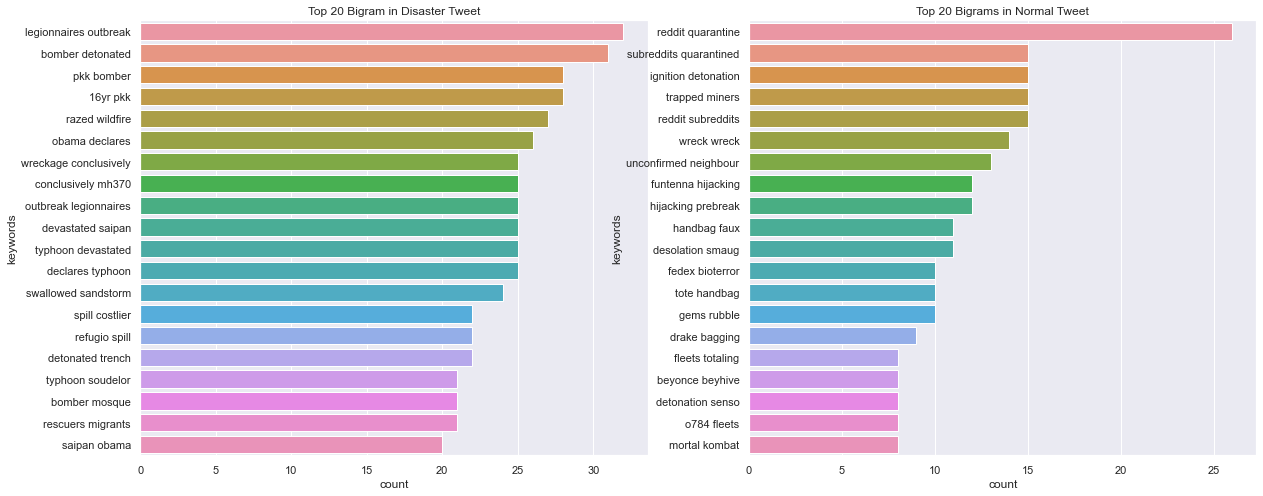

In [311]:
plot_ngram(top_20_bigrams_disaster, top_20_bigrams_normal)

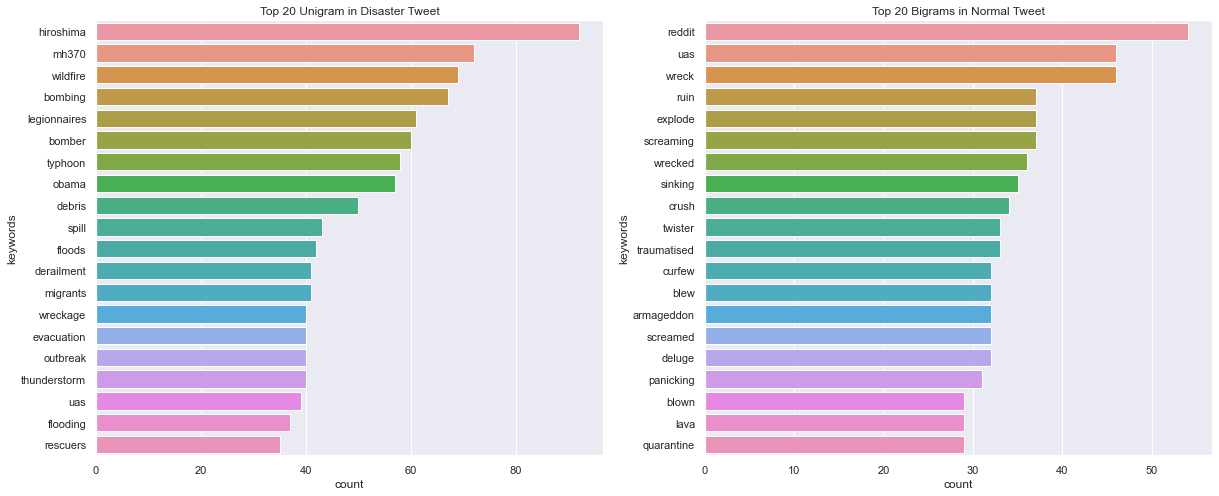

In [312]:
plot_ngram(top_20_unigrams_disaster, top_20_unigrams_normal, ngram='Unigram')

In [313]:
from textacy.extract.kwic import keyword_in_context
import random

In [314]:
def kwic(doc_series, keyword, window=35, print_samples=5):

    def add_kwic(text):
        kwic_list.extend(keyword_in_context(text, keyword, ignore_case=True,
                              window_width=window))

    kwic_list = []
    doc_series.map(add_kwic)

    if print_samples is None or print_samples==0:
        return kwic_list
    else:
        k = min(print_samples, len(kwic_list))
        print(f"{k} random samples out of {len(kwic_list)} " + \
              f"contexts for '{keyword}':")
        print("------------------------------------------------\n")
        for sample in random.sample(list(kwic_list), k):
            print(re.sub(r'[\n\t]', '\t', sample[0])+'  '+ \
                  sample[1]+'\t'+\
                  re.sub(r'[\n\t]', '\t', sample[2]))
            print()

In [315]:
kwic(train[DISASTER_TWEETS]['clean_text'], '16yr', print_samples=5, window=40)

5 random samples out of 28 contexts for '16yr':
------------------------------------------------

  16yr	 old pkk suicide bomber who detonated bo

bestnaijamade   16yr	 old pkk suicide bomber who detonated bo

  16yr	 old pkk suicide bomber who detonated bo

pic of   16yr	 old pkk suicide bomber who detonated bo

pic of   16yr	 old pkk suicide bomber who detonated bo



In [316]:
kwic(train[DISASTER_TWEETS]['clean_text'], 'mh370', print_samples=5, window=40)

5 random samples out of 73 contexts for 'mh370':
------------------------------------------------

art of missing malaysia airlines flight   mh370	 vice news

alaysia pm confirms wreckage belongs to   mh370	

plane debris is from missing   mh370	

confirmed the debris from   mh370	

er says reunion island wreckage is from   mh370	 via



In [317]:
kwic(train[~DISASTER_TWEETS]['clean_text'], 'o784', print_samples=5, window=40)

5 random samples out of 8 contexts for 'o784':
------------------------------------------------

ack eye a space battle occurred at star   o784	 involving fleets totaling ships with de

ack eye a space battle occurred at star   o784	 involving fleets totaling ships with de

ack eye a space battle occurred at star   o784	 involving fleets totaling ships with de

ack eye a space battle occurred at star   o784	 involving fleets totaling ships with de

ack eye a space battle occurred at star   o784	 involving fleets totaling ships with de



#### Analysing Keyword

In [318]:
print(f"Sample Keywords are: {train['keyword'].sample(4).values}")
print(f"Number of Unique Keywords: {train['keyword'].nunique()}")

Sample Keywords are: ['crash' 'sandstorm' 'collapse' 'injury']
Number of Unique Keywords: 221


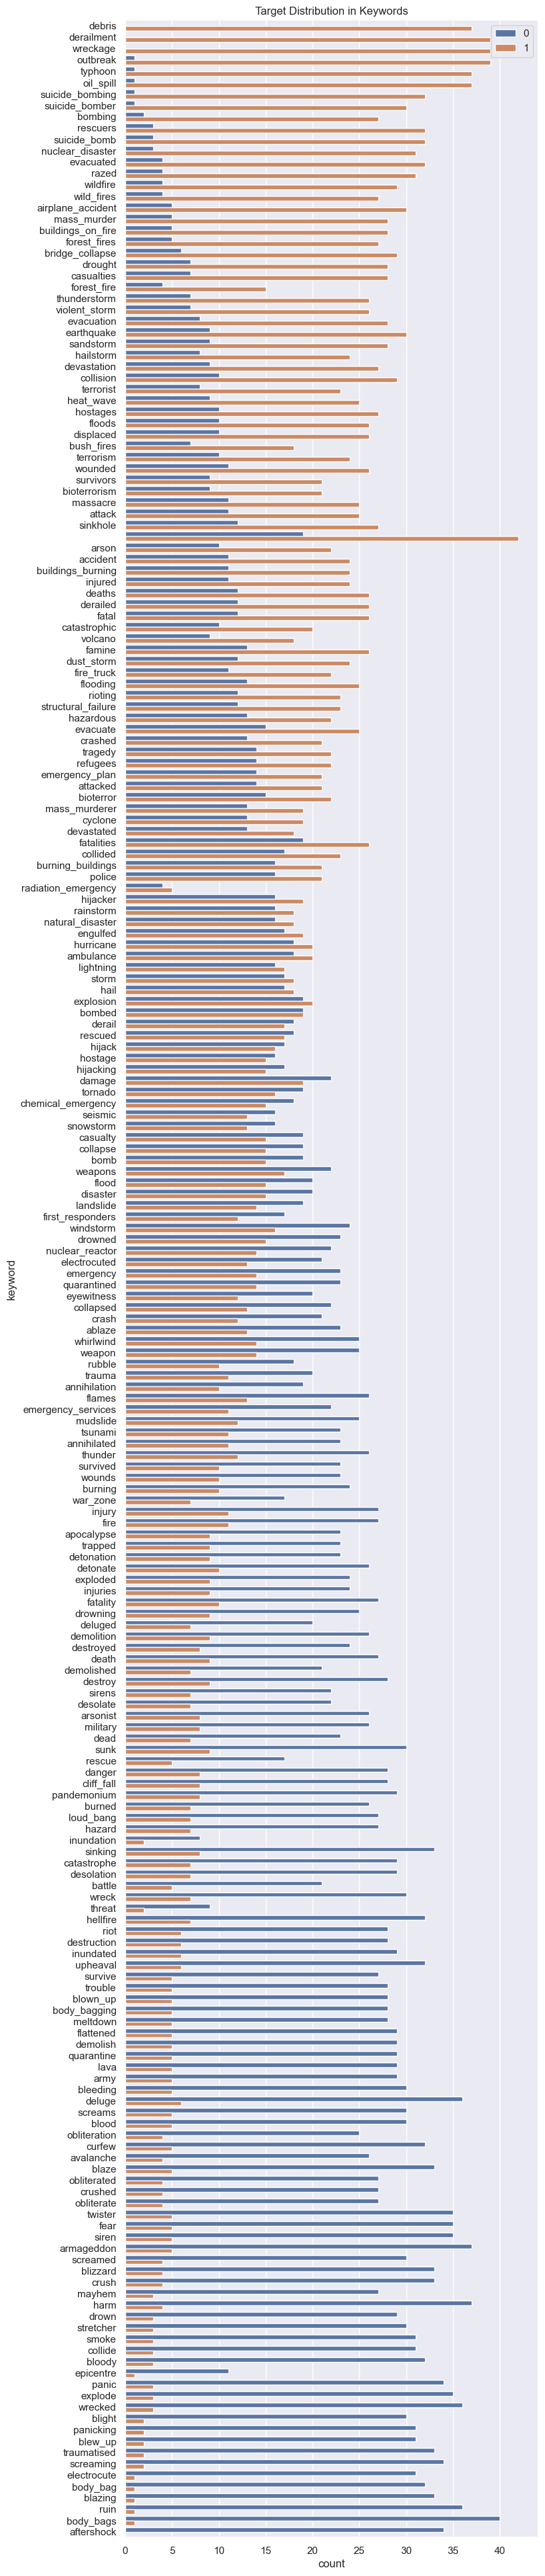

In [373]:
train['target_mean'] = train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize = (8, 50), dpi = 100)

sns.countplot(y=train.sort_values(by='target_mean', ascending = False)['keyword'],
              hue=train.sort_values(by='target_mean', ascending = False)['target'],
              )

plt.tick_params(axis='x')
plt.tick_params(axis='y')
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

In [321]:
from collections import Counter

def counter(train):
    disaster_series = train[DISASTER_TWEETS]['keyword'].dropna()
    normal_series = train[~DISASTER_TWEETS]['keyword'].dropna()
    disaster_series = disaster_series[disaster_series.isin(normal_series.values)]
    normal_series = normal_series[normal_series.isin(disaster_series.values)]
    count_disaster = Counter(disaster_series)
    count_normal = Counter(normal_series)
    
    df = pd.DataFrame({'keys': count_disaster.keys()}, columns=['keys'])
    df['count_keyword_disaster'] = df['keys'].map(lambda key: count_disaster[key])
    df['count_keyword_normal'] = df['keys'].map(lambda key: count_normal[key])
    return df

In [322]:
data = counter(train).head(40)

Text(0.5, 1.0, 'Keywords in Normal Tweet')

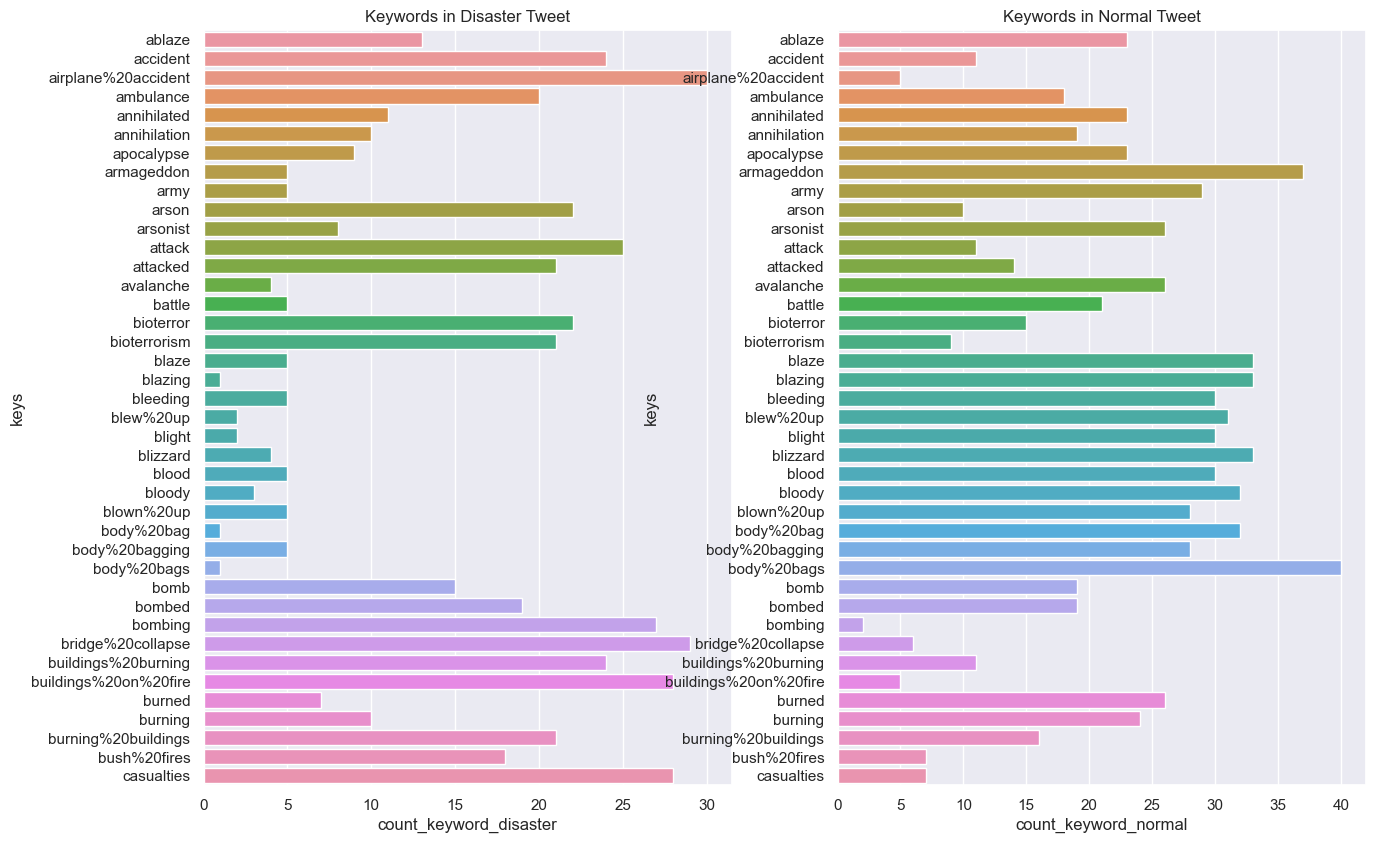

In [323]:
fig, (ax,ax1) = plt.subplots(1, 2, figsize = (15, 10), dpi = 100)

sns.barplot(data=data, x='count_keyword_disaster', y='keys', orient='h', ax=ax)
sns.barplot(data=data, x='count_keyword_normal', y='keys', orient='h', ax=ax1)
ax.set_title(f"Keywords in Disaster Tweet")
ax1.set_title(f"Keywords in Normal Tweet")

In [324]:
train['keyword'].sample(4)

5789             rioting
3174    emergency%20plan
2653            detonate
1896             crushed
Name: keyword, dtype: object

In [325]:
train['keyword'].fillna("", inplace = True)
train['keyword'] = train['keyword'].map(lambda word: re.sub(r"%20", '_', word))

In [326]:
train['keyword'].sample(4)

3272         engulfed
4870    mass_murderer
5193      obliterated
4003           floods
Name: keyword, dtype: object

In [349]:
train['clean_text'] = train['keyword'] + ': ' + train['clean_text']

## BaseLine Model

In [368]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression



In [369]:
X_train, X_test, Y_train, Y_test = train_test_split(train['clean_text'], train['target'],
                                   test_size = .2, random_state = 42,
                                   stratify  = train['target'])

In [370]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words=set(top_10000[0].values), min_df=2)

X_train_tf = vectorizer.fit_transform(X_train)

X_test_tf = vectorizer.transform(X_test)

In [371]:
svc = SVC(kernel="rbf", tol=1e-2, C=2, random_state=42)

svc.fit(X_train_tf, Y_train)

Y_pred_svc = svc.predict(X_test_tf)
print(classification_report(Y_test, Y_pred_svc))

              precision    recall  f1-score   support

           0       0.76      0.87      0.81       869
           1       0.78      0.63      0.70       654

    accuracy                           0.77      1523
   macro avg       0.77      0.75      0.75      1523
weighted avg       0.77      0.77      0.76      1523



In [372]:
naive = MultinomialNB(alpha=1.0)

naive.fit(X_train_tf, Y_train)

Y_pred_naive = naive.predict(X_test_tf)
print(classification_report(Y_test, Y_pred_naive))

              precision    recall  f1-score   support

           0       0.75      0.90      0.82       869
           1       0.82      0.61      0.70       654

    accuracy                           0.77      1523
   macro avg       0.79      0.75      0.76      1523
weighted avg       0.78      0.77      0.77      1523

